<a href="https://colab.research.google.com/github/Arjun-08/Community-detection-algorithm/blob/main/COMMUNITY_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATASET**

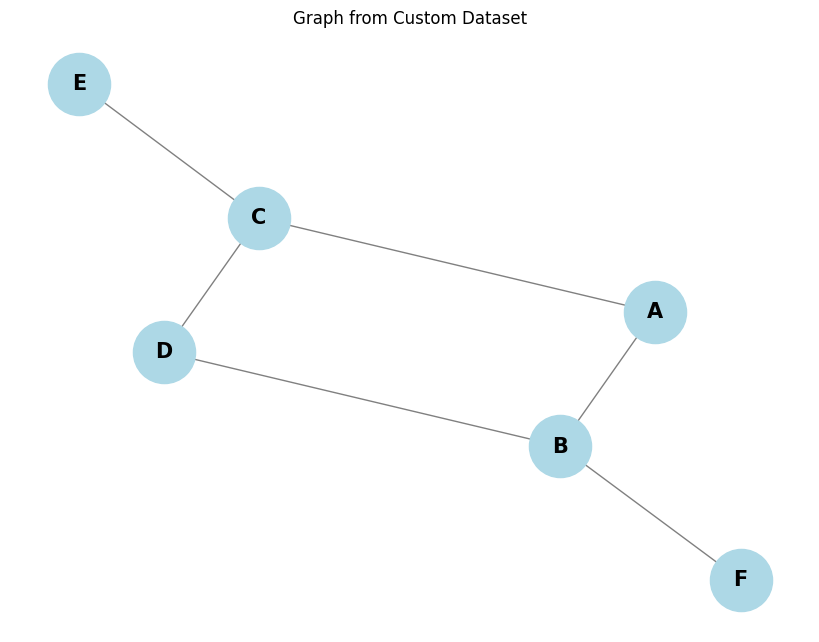

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph() # Initialize a graph

edges = [
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'F'),
    ('B', 'D'),
    ('C', 'D'),
    ('C', 'E')
]

with open('graph_dataset.txt', 'w') as file:
    for edge in edges:
        file.write(f"{edge[0]} {edge[1]}\n")


# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=2000, font_size=15, font_color='black', font_weight='bold', edge_color='gray')
plt.title("Graph from Custom Dataset")
plt.show()


Girvan Newman algorithm for community detection

In [13]:
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import networkx as nx

In [14]:
def load_graph(file_path):
    graph = defaultdict(set)
    with open(file_path, 'r') as file:
        for line in file:
            node1, node2 = line.strip().split()
            graph[node1].add(node2)
            graph[node2].add(node1)
    return graph

def calculate_betweenness(graph):
    betweenness = defaultdict(float)
    for node in graph:
        S, P, sigma = bfs_shortest_path(graph, node)
        betweenness = accumulate_edge_betweenness(betweenness, S, P, sigma, node)
    return betweenness

def bfs_shortest_path(graph, source):
    S = []
    P = {v: [] for v in graph}
    sigma = dict.fromkeys(graph, 0.0)
    sigma[source] = 1.0
    D = {source: 0}
    Q = deque([source])

    while Q:
        v = Q.popleft()
        S.append(v)
        for w in graph[v]:
            if w not in D:
                Q.append(w)
                D[w] = D[v] + 1
            if D[w] == D[v] + 1:
                sigma[w] += sigma[v]
                P[w].append(v)

    return S, P, sigma

def accumulate_edge_betweenness(betweenness, S, P, sigma, source):
    delta = dict.fromkeys(S, 0.0)
    while S:
        w = S.pop()
        for v in P[w]:
            c = (sigma[v] / sigma[w]) * (1.0 + delta[w])
            if (v, w) in betweenness:
                betweenness[(v, w)] += c
            else:
                betweenness[(w, v)] += c
            delta[v] += c
        if w != source:
            delta[w] += 1
    return betweenness

def girvan_newman_all_steps(graph):
    graph = graph.copy()
    while len(graph) > 1:
        betweenness = calculate_betweenness(graph)
        if not betweenness:
            break

        max_betweenness_edge = max(betweenness, key=betweenness.get)
        graph[max_betweenness_edge[0]].remove(max_betweenness_edge[1])
        graph[max_betweenness_edge[1]].remove(max_betweenness_edge[0])

        components = list(connected_components(graph))
        yield components

def connected_components(graph):
    visited = set()
    for node in graph:
        if node not in visited:
            component = bfs_component(graph, node, visited)
            yield component

def bfs_component(graph, start, visited):
    queue = deque([start])
    component = set()
    while queue:
        node = queue.popleft()
        if node not in visited:
            visited.add(node)
            component.add(node)
            queue.extend(graph[node] - visited)
    return component

def visualize_communities(graph, communities, iteration):
    plt.figure(figsize=(12, 12))
    plt.clf()

    G = nx.Graph()

    for i, community in enumerate(communities):
        if len(community) == 0:
            continue
        G.add_nodes_from(community)
        for node in community:
            for neighbor in graph[node]:
                if neighbor in community:
                    G.add_edge(node, neighbor)

    pos = nx.spring_layout(G, seed=42, k=0.3)

    color_map = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink']
    node_colors = []
    for node in G.nodes():
        for i, community in enumerate(communities):
            if node in community:
                node_colors.append(color_map[i % len(color_map)])
                break

    nx.draw_networkx(G, pos, node_color=node_colors, with_labels=True, node_size=500, font_size=10, edge_color='gray')

    plt.title(f"Communities - Iteration {iteration}")
    plt.show()

Iteration 1:
  Community 1: ['A', 'B', 'C', 'D', 'F']
  Community 2: ['E']


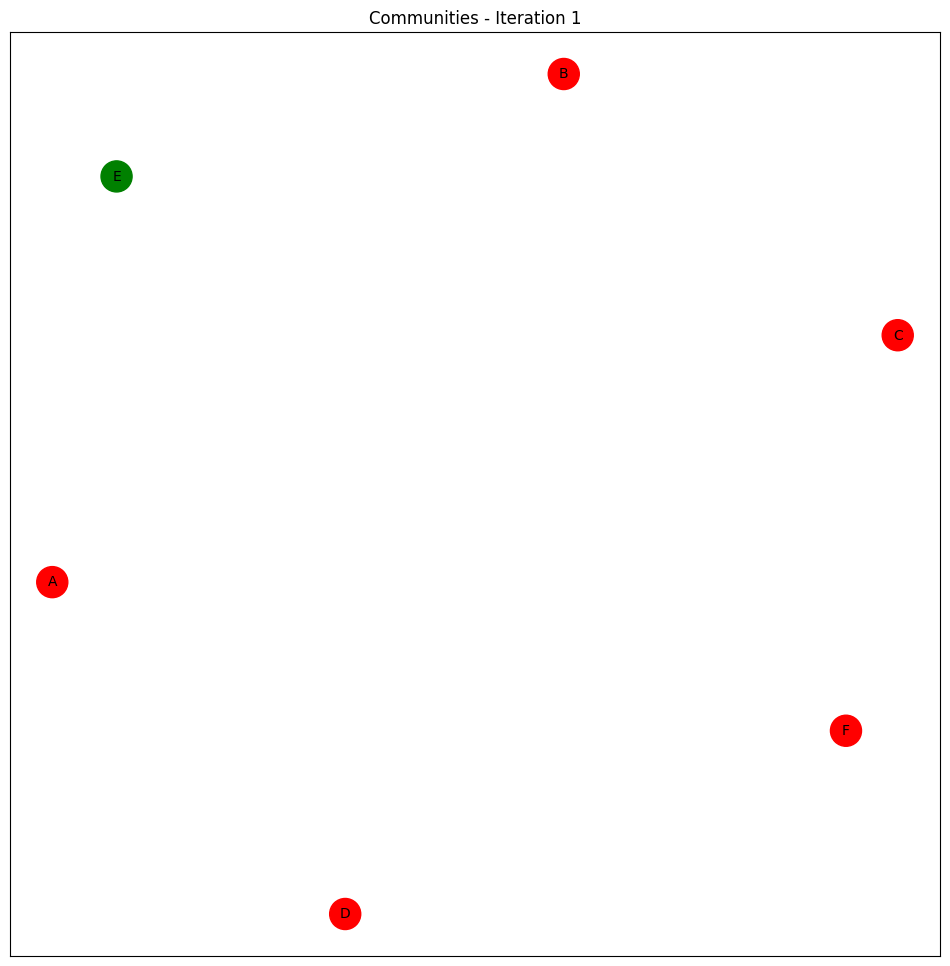

Iteration 2:
  Community 1: ['A', 'B', 'C', 'D']
  Community 2: ['F']
  Community 3: ['E']


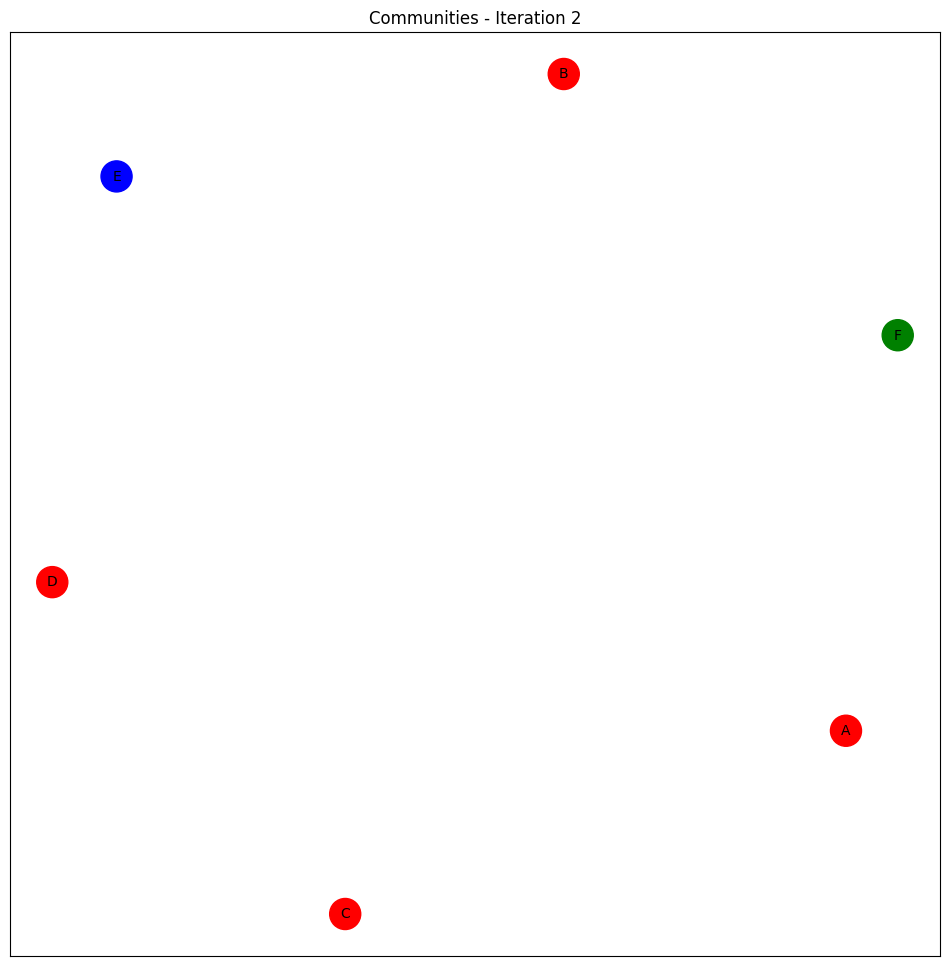

Iteration 3:
  Community 1: ['A', 'B', 'C', 'D']
  Community 2: ['F']
  Community 3: ['E']


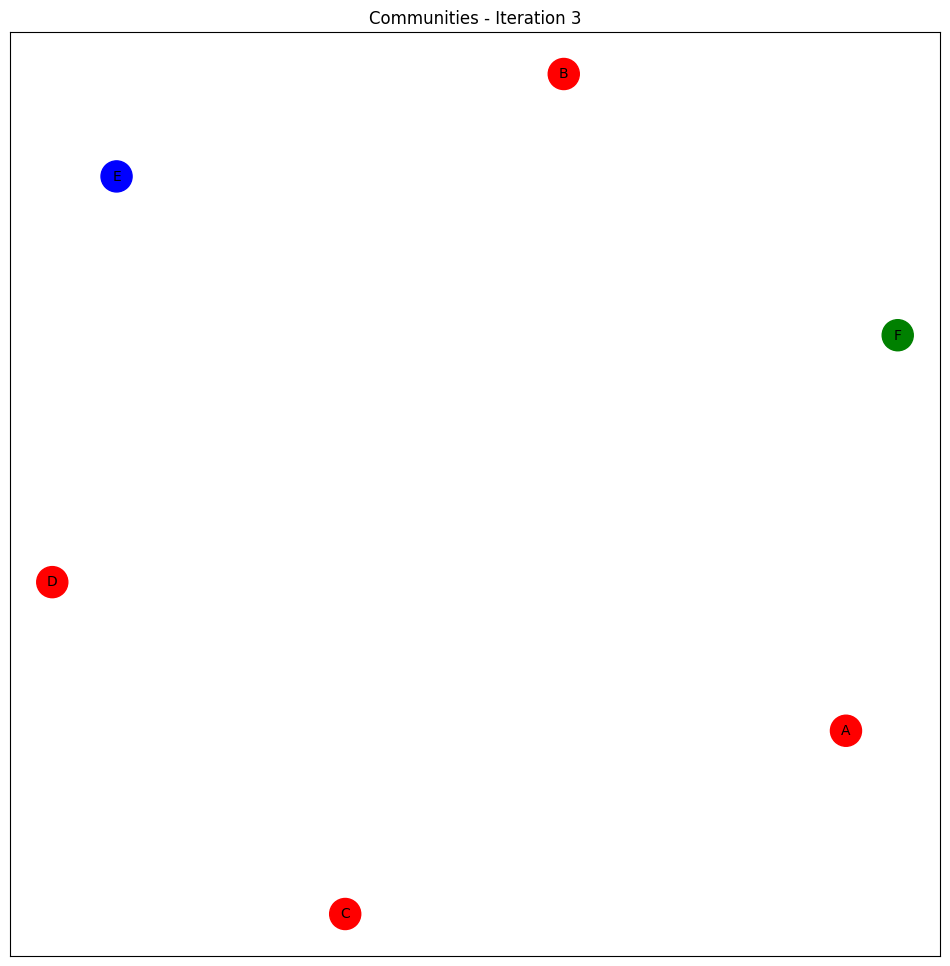

Iteration 4:
  Community 1: ['A', 'B']
  Community 2: ['C', 'D']
  Community 3: ['F']
  Community 4: ['E']


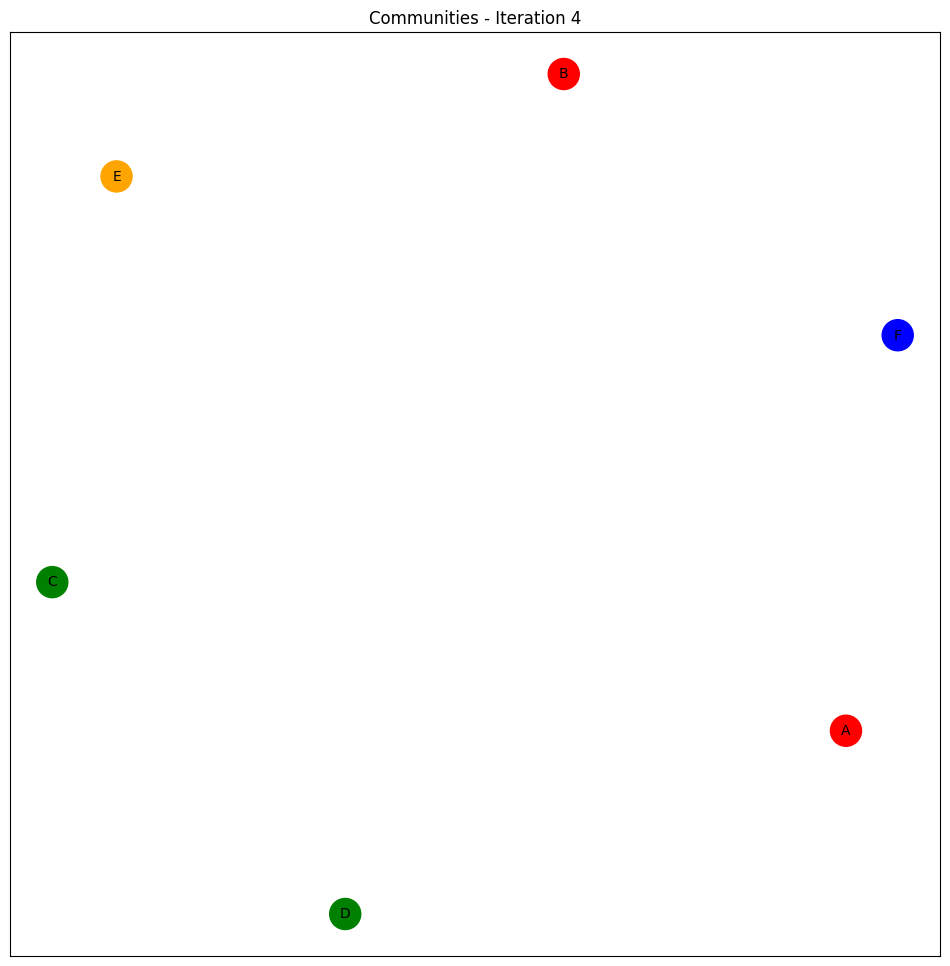

Iteration 5:
  Community 1: ['A']
  Community 2: ['B']
  Community 3: ['C', 'D']
  Community 4: ['F']
  Community 5: ['E']


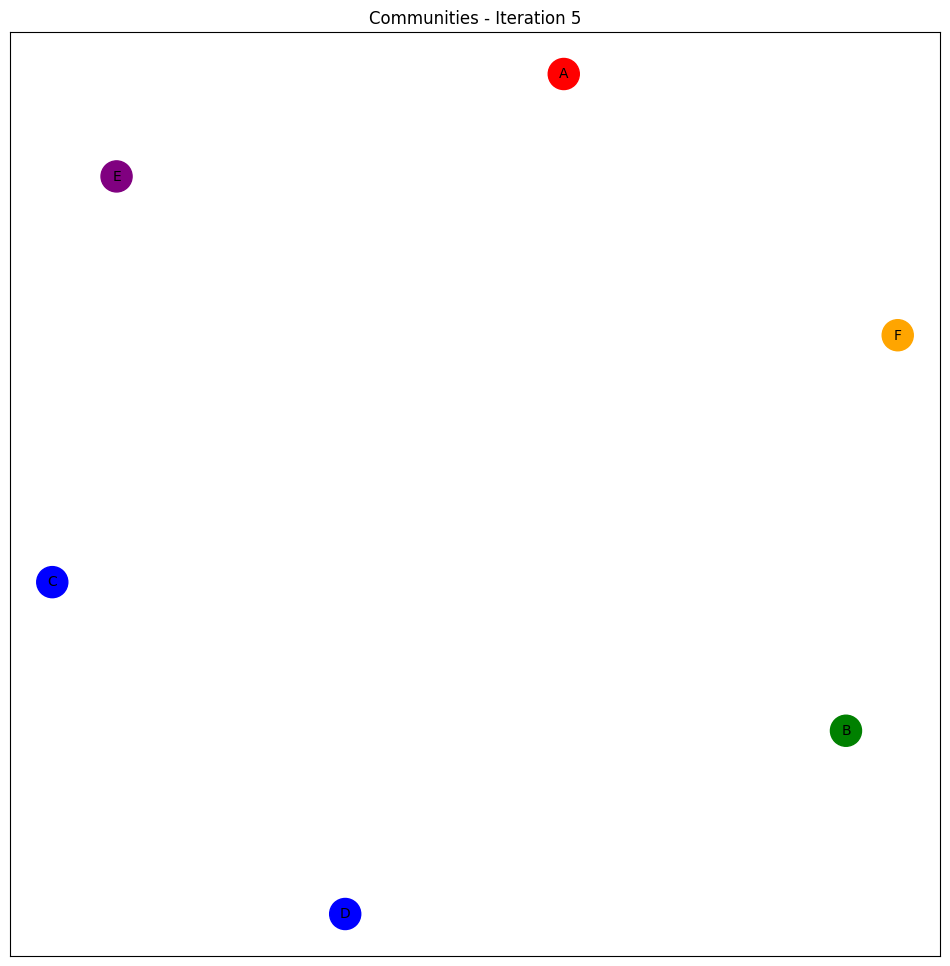

Iteration 6:
  Community 1: ['A']
  Community 2: ['B']
  Community 3: ['C']
  Community 4: ['F']
  Community 5: ['D']
  Community 6: ['E']


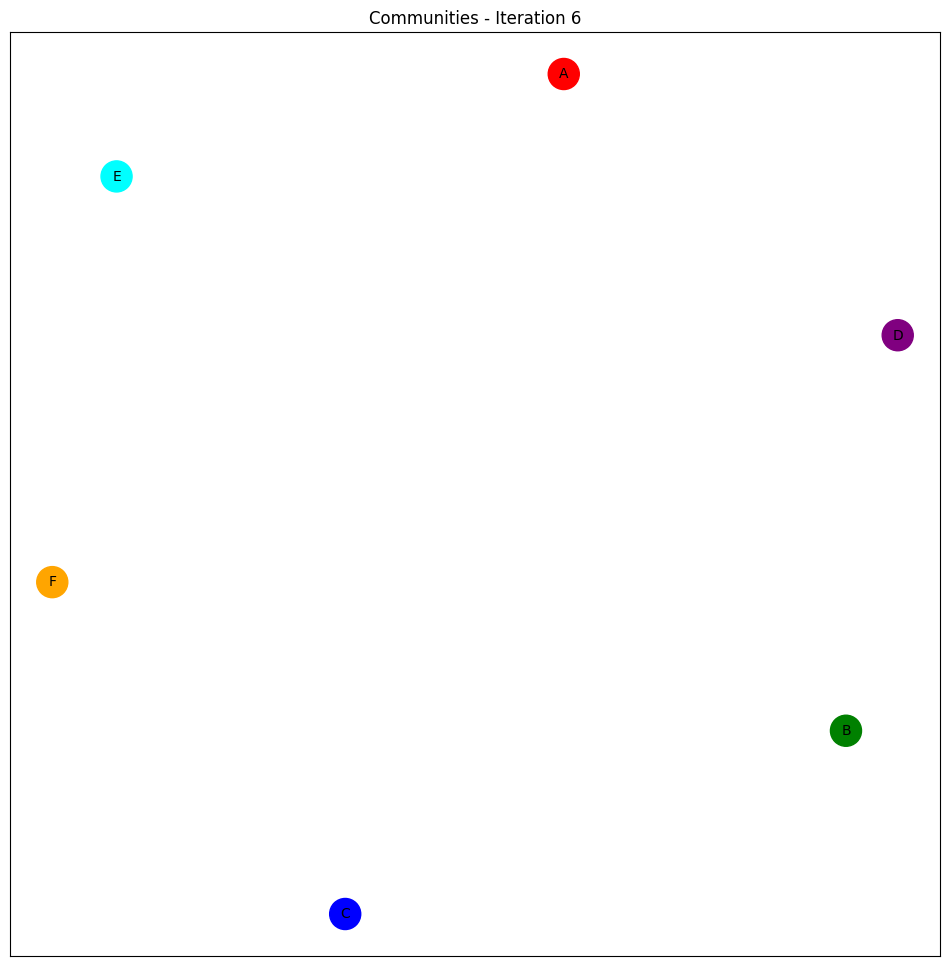

In [8]:
def main():
    graph = load_graph('/content/graph_dataset.txt')

    all_communities = list(girvan_newman_all_steps(graph))

    for i, communities in enumerate(all_communities):
        print(f"Iteration {i + 1}:")
        for j, community in enumerate(communities):
            print(f"  Community {j + 1}: {sorted(community)}")

        visualize_communities(graph, communities, i + 1)

if __name__ == "__main__":
    main()


 LOUVAIN ALGO

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import numpy as np

In [10]:
def load_graph(file_path):
    graph = defaultdict(set)
    with open(file_path, 'r') as file:
        for line in file:
            node1, node2 = line.strip().split()
            graph[node1].add(node2)
            graph[node2].add(node1)
    return graph

def modularity(graph, communities):
    m = sum(len(neighbors) for node, neighbors in graph.items()) / 2
    q = 0.0

    for community in communities:
        subgraph = {node: graph[node] for node in community}
        L_c = sum(len(subgraph[node].intersection(community)) for node in community) / 2
        d_c = sum(len(graph[node]) for node in community) / 2
        q += (L_c / m) - (d_c / (2 * m)) ** 2
    return q


def louvain_one_iteration(graph):
    communities = {node: node for node in graph}
    modularity_gain = defaultdict(float)

    for node in graph:
        best_community = communities[node]
        best_gain = 0.0

        for neighbor in graph[node]:
            if neighbor != node:
                current_community = communities[neighbor]
                if current_community != communities[node]:
                    temp_community = communities[node]
                    communities[node] = current_community

                    new_modularity = modularity(graph, [list(communities.keys())])
                    gain = new_modularity - modularity(graph, [list(communities.keys())])

                    communities[node] = temp_community

                    if gain > best_gain:
                        best_gain = gain
                        best_community = current_community

        communities[node] = best_community

    community_dict = defaultdict(set)
    for node, comm in communities.items():
        community_dict[comm].add(node)

    return list(community_dict.values())

def plot_graph_with_communities(graph, communities):
    G = nx.Graph()
    for node in graph:
        G.add_node(node)
        for neighbor in graph[node]:
            if not G.has_edge(node, neighbor):
                G.add_edge(node, neighbor)

    pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))
    colors = plt.get_cmap('tab10')
    color_map = {}

    for i, community in enumerate(communities):
        for node in community:
            color_map[node] = colors(i)

    nx.draw(G, pos, node_color=[color_map.get(node, 'gray') for node in G.nodes],
            with_labels=True, node_size=50, font_size=10, edge_color='gray')
    plt.title('Graph with Detected Communities (One Iteration of Louvain)')
    plt.show()



Detected communities after one iteration:
Community 1: {'A'}
Community 2: {'B'}
Community 3: {'C'}
Community 4: {'F'}
Community 5: {'D'}
Community 6: {'E'}


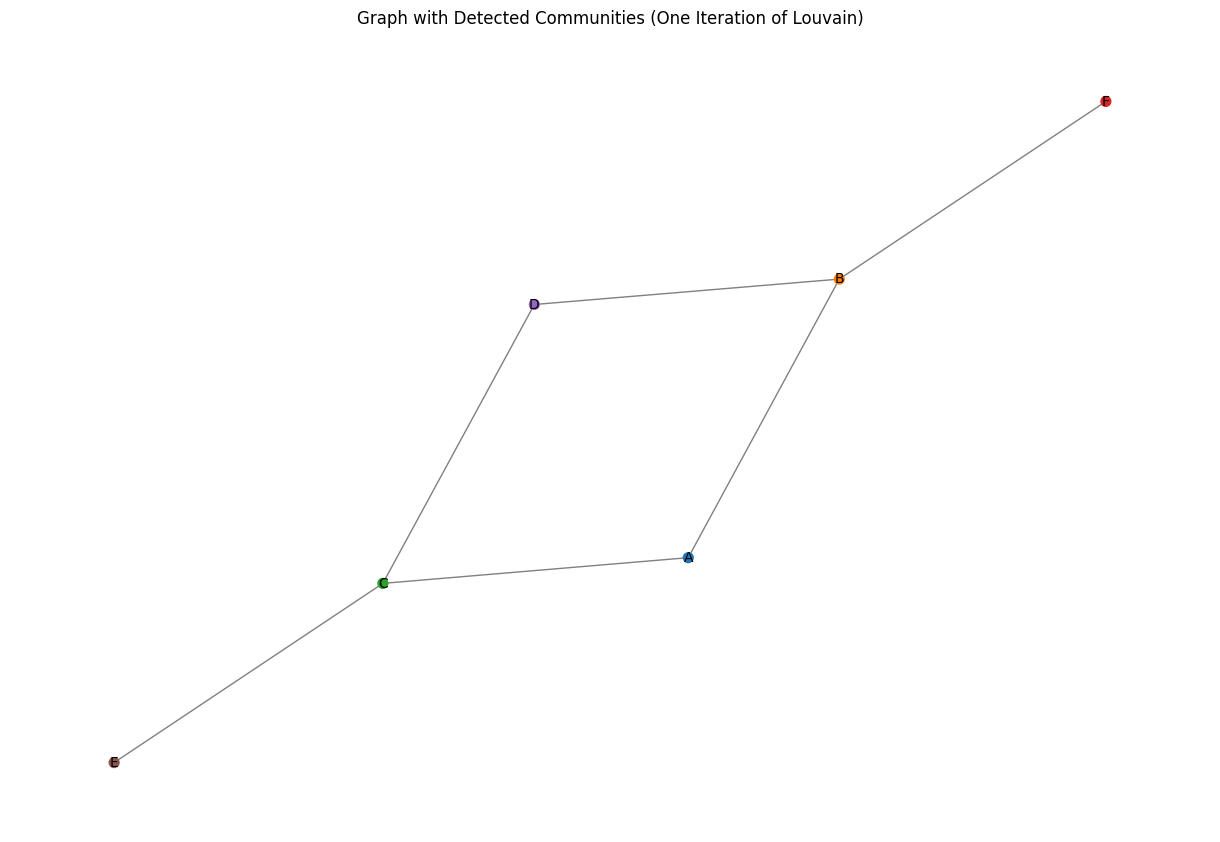

In [11]:
def main():
    file_path = '/content/graph_dataset.txt'
    graph = load_graph(file_path)

    communities = louvain_one_iteration(graph)

    print("Detected communities after one iteration:")
    for i, community in enumerate(communities):
        print(f"Community {i + 1}: {community}")

    plot_graph_with_communities(graph, communities)

if __name__ == "__main__":
    main()
